## 영역 분할


- 객체 인식 및 분류: 영역 분할을 통해 장비, 자재, 인력 등을 식별하고 분류
- 안전 모니터링 강화: 보행자, 차량 등의 동적 요소를 실시간으로 감지하고 추적함으로써 현장의 안전을 효과적으로 모니터링. 특히 위험 구역 내 무단 침입자나 장비의 부적절한 사용을 감지
- 도로 및 인프라 계획 최적화: 도시 환경의 도로 및 건물 구조에 대한 세분화된 정보를 통해, 건설 현장 부변의 인프라 계획을 좀 더 효율적으로 수립.
- 작업 진행 상황 분석: 영역 분할을 사용하여 건설 현장의 진행 사오항을 정빌하게 분석


In [59]:
# 데이터 처리 및 분석 모듈
import numpy as np
import pandas as pd

# 데이터 시각화 도구
import matplotlib.pyplot as plt
import seaborn as sns

# 이미지 처리 과련 모듈
from PIL import Image
from glob import glob

# 진행 상태 표시
from tqdm import tqdm


In [60]:
# 데이터 확인
import os


def get_image_path(directory):
    return glob(os.path.join(directory, "*.jpg"))


train_dir = "cityscapes/train/"
val_dir = "cityscapes/val/"

train_image_path = get_image_path(train_dir)
val_image_path = get_image_path(val_dir)

print(len(train_image_path), len(val_image_path))


2975 500


In [61]:
# 레이블 네임 스페이스 정의


# name: 레이블의 이름, id: 각 레이블에 할당된 고유한 정수, trainId: 훈련 과정에서 사용되는 아이디, category, categoryId: 레이블이 속한
# 카테고리와 아이디, hasInstance: 레이블이 단일 인스턴스를 구별할 수 있는지 여부를 결정, ignoreInEval: 평가 과정에서 레이블을 무시할지 여부 결정
# 정의된 레이블 목록은 데이터 셋트의 이미지에 존재하는 다양한 객체들을 세분화하고 분류하는데 사용
# 각 클래스별 상세 정보를 통해 영역 분할 알고리즘이 각 객체를 정확하게 식별하고, 이를 바탕으로 다양한 분석과 시각화 작업을 수행


from collections import namedtuple

Label = namedtuple(
    "Label",
    [
        "name",
        "id",
        "trainId",
        "category",
        "categoryId",
        "hasInstances",
        "ignoreInEval",
        "color",
    ],
)


labels = [
    Label("unlabeled", 0, 255, "void", 0, False, True, (0, 0, 0)),
    Label("egovehicle", 1, 255, "void", 0, False, True, (0, 0, 0)),
    Label("rectificationborder", 2, 255, "void", 0, False, True, (0, 0, 0)),
    Label("outofroi", 3, 255, "void", 0, False, True, (0, 0, 0)),
    Label("static", 4, 255, "void", 0, False, True, (0, 0, 0)),
    Label("dynamic", 5, 255, "void", 0, False, True, (111, 74, 0)),
    Label("ground", 6, 255, "void", 0, False, True, (81, 0, 81)),
    Label("road", 7, 0, "ground", 1, False, False, (128, 64, 128)),
    Label("sidewalk", 8, 1, "ground", 1, False, False, (244, 35, 232)),
    Label("parking", 9, 255, "ground", 1, False, True, (250, 170, 160)),
    Label("railtrack", 10, 255, "ground", 1, False, True, (230, 150, 140)),
    Label("building", 11, 2, "construction", 2, False, False, (70, 70, 70)),
    Label("wall", 12, 3, "construction", 2, False, False, (102, 102, 156)),
    Label("fence", 13, 4, "construction", 2, False, False, (190, 153, 153)),
    Label("guardrail", 14, 255, "construction", 2, False, True, (180, 165, 180)),
    Label("bridge", 15, 255, "construction", 2, False, True, (150, 100, 100)),
    Label("tunnel", 16, 255, "construction", 2, False, True, (150, 120, 90)),
    Label("pole", 17, 5, "object", 3, False, False, (153, 153, 153)),
    Label("polegroup", 18, 255, "object", 3, False, True, (153, 153, 153)),
    Label("trafficlight", 19, 6, "object", 3, False, False, (250, 170, 30)),
    Label("trafficsign", 20, 7, "object", 3, False, False, (220, 220, 0)),
    Label("vegetation", 21, 8, "nature", 4, False, False, (107, 142, 35)),
    Label("terrain", 22, 9, "nature", 4, False, False, (152, 251, 152)),
    Label("sky", 23, 10, "sky", 5, False, False, (70, 130, 180)),
    Label("person", 24, 11, "human", 6, True, False, (220, 20, 60)),
    Label("rider", 25, 12, "human", 6, True, False, (255, 0, 0)),
    Label("car", 26, 13, "vehicle", 7, True, False, (0, 0, 142)),
    Label("truck", 27, 14, "vehicle", 7, True, False, (0, 0, 70)),
    Label("bus", 28, 15, "vehicle", 7, True, False, (0, 60, 100)),
    Label("caravan", 29, 255, "vehicle", 7, True, True, (0, 0, 90)),
    Label("trailer", 30, 255, "vehicle", 7, True, True, (0, 0, 110)),
    Label("train", 31, 16, "vehicle", 7, True, False, (0, 80, 100)),
    Label("motorcycle", 32, 17, "vehicle", 7, True, False, (0, 0, 230)),
    Label("bicycle", 33, 18, "vehicle", 7, True, False, (119, 11, 32)),
    Label("licenseplate", 34, 19, "vehicle", 7, False, True, (0, 0, 142)),
]


In [62]:
# 하이퍼 파라미터 설정
n_filters = 64  # 모델의 합성곱 층에 사용될 필터 수
kernel_size = 3  # 합성곱 커널 사이즈
n_classes = len(labels)  # 데이터 세트에 정의된 클래스 수
image_size = 128
epochs = 15
batch_size = 16

model_checkpoint_filepath = "./cityscapes-unet.weights.h5"  # 모델 체크가 완료됐을 때 저장될 모델 파일(가중치만 추출)

id2color = {
    label.id: np.asarray(label.color) for label in labels
}  # 모델의 시각화 및 결과 해석에 사용
# 각 클래스 아이디에 대응하는 색상 정보를 저장해서 시각적으로 사진에 덧입힌다


In [63]:
# 이미지와 마스크 분리;
# mask: 필요한 부분만을 칠하기 위해 불필요한 부분을 원하는 형태로 가리는 것
def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)  # 이미지 파일 로드
    image, mask = (
        image_mask.crop([0, 0, 256, 256]),
        image_mask.crop([256, 0, 512, 256]),
    )  # 이미지 마스크 분리
    image = image.resize((image_size, image_size))  # 이미지 크기 조정
    mask = mask.resize((image_size, image_size))  # 마스크 크기 조정
    image = np.array(image) / 255.0  # 정규화
    mask = np.array(mask)

    return image, mask


# 마스크 픽셀별 가장 가까운 레이블 ID 찾기
def find_closest_labels_vectorized(mask, mapping):
    closest_distance = np.full(
        [mask.shape[0], mask.shape[1]], 10000
    )  # 초기 거리값 지정
    closest_category = np.full(
        [mask.shape[0], mask.shape[1]], None
    )  # 초기 카테고리 지정
    for id, color in mapping.items():
        dist = np.sqrt(
            np.linalg.norm(mask - color.reshape([1, 1, -1]), axis=-1)
        )  # 색상 거리 계산
        is_closer = closest_distance > dist  # 더 가까운 거리 확인
        closest_distance = np.where(is_closer, dist, closest_distance)  # 거리 업데이트
        closest_category = np.where(
            is_closer, id, closest_category
        )  # 카테고리 업데이트
    return closest_category


In [64]:
# 훈련 및 검증 데이터 세트 구축
train_images = []
train_masks = []
train_masks_enc = []
val_images = []
val_masks = []
val_masks_enc = []

# glob은 파일들의 리스트를 뽑을 때 사용. 인자로 받은 패턴과 이름이 일치하는 모든 파일과 데렉토리의 리스트 반환
train_lists = glob(f"{train_dir}*.jpg")
val_lists = glob(f"{val_dir}*.jpg")
print(len(train_lists), len(val_lists))

for train_file in tqdm(train_lists, desc="Building Training Dataset: "):
    image, mask = image_mask_split(train_file, image_size)
    train_images.append(image)
    train_masks.append(mask)
    # 마스크 이미지를 레이블로 인코딩한다. 모델이 학습할 수 있는 형태의 데이터 세트를 생성
    train_masks_enc.append(find_closest_labels_vectorized(mask, id2color))

for val_file in tqdm(val_lists, desc="Building Validation Dataset: "):
    image, mask = image_mask_split(val_file, image_size)
    val_images.append(image)
    val_masks.append(mask)
    val_masks_enc.append(find_closest_labels_vectorized(mask, id2color))


2975 500


Building Training Dataset:   0%|                                                              | 0/2975 [00:00<?, ?it/s]

Building Validation Dataset: 100%|███████████████████████████████████████████████████| 500/500 [00:48<00:00, 10.38it/s]


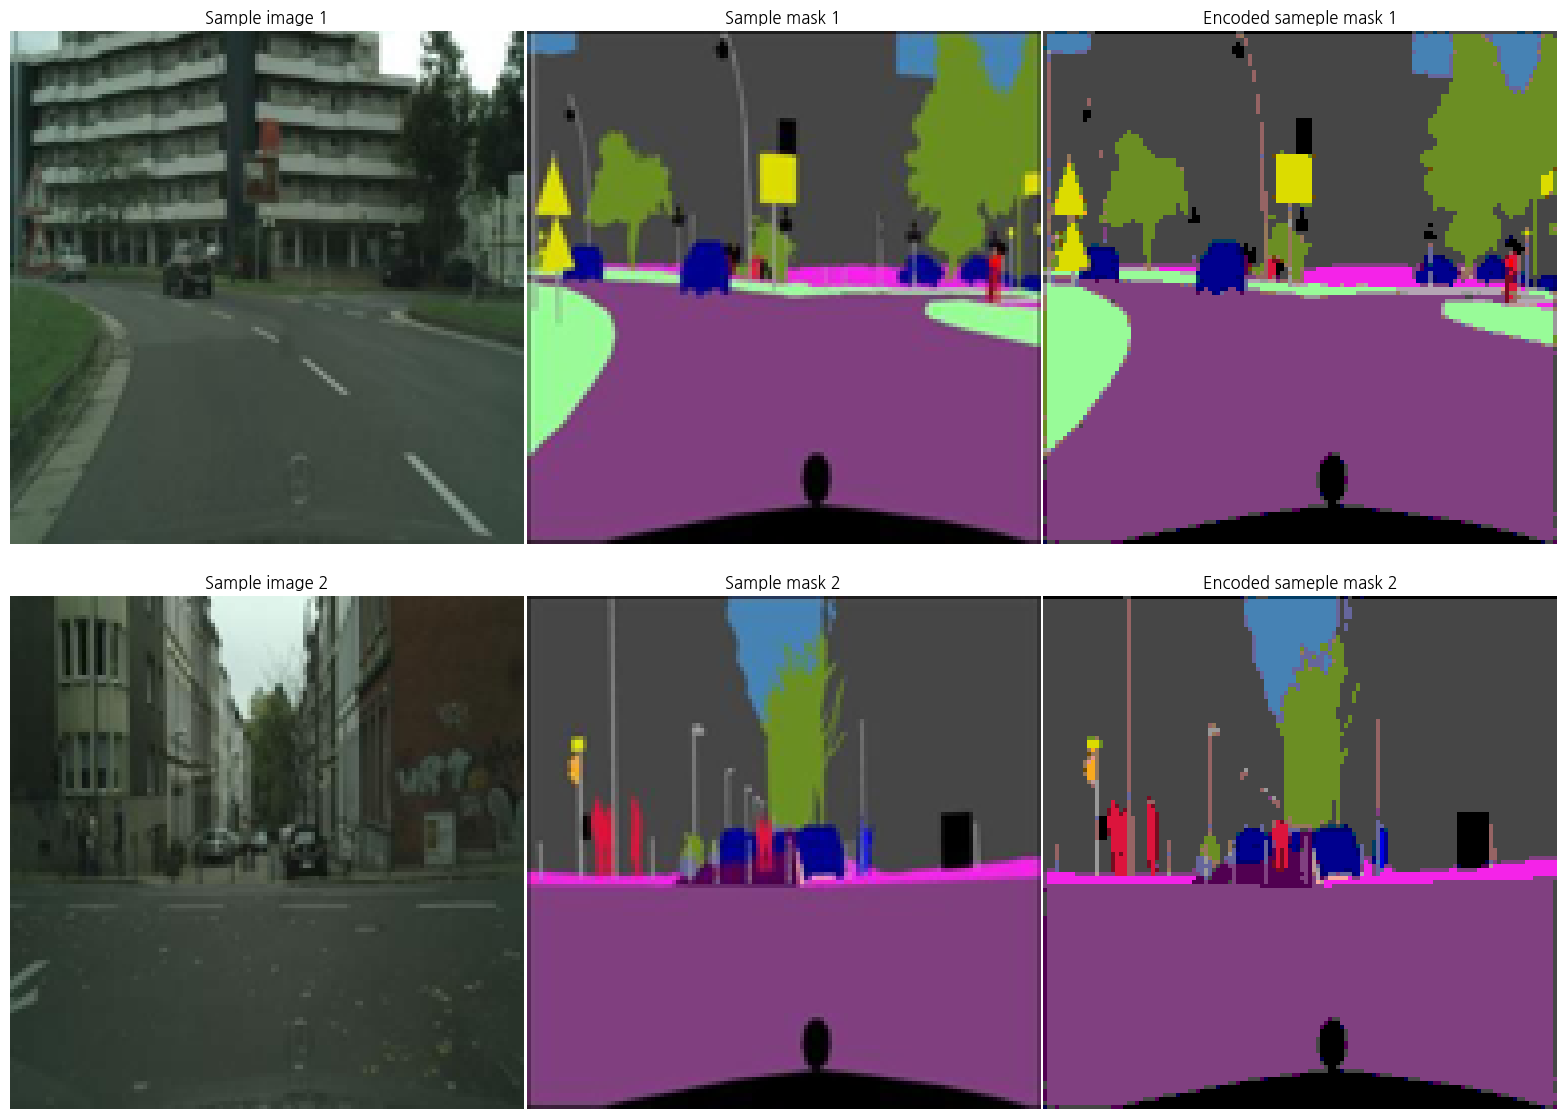

In [72]:
# 훈련 데이터 중 두 개의 샘플 이미지의 마스크 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=[20, 14])


for i in range(2):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_enc[i]

    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[enc[row, col]]
            tmp = tmp.astype("uint8")

    plt.subplot(2, 3, i * 3 + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.gca().set_title("Sample image {}".format(str(i + 1)))

    plt.subplot(2, 3, i * 3 + 2)
    plt.imshow(msk)
    plt.axis("off")
    plt.gca().set_title("Sample mask {}".format(str(i + 1)))

    plt.subplot(2, 3, i * 3 + 3)
    plt.imshow(tmp)
    plt.axis("off")
    plt.gca().set_title("Encoded sameple mask {}".format(str(i + 1)))

plt.subplots_adjust(wspace=0, hspace=0.1)


In [73]:
# 이미지와 마스크를 numpy 배열로 변환하고 데이터 타입을 'float32'로 설정
train_images = np.stack(train_images).astype("float32")
train_masks_enc = np.stack(train_masks_enc).astype("float32")

val_images = np.stack(val_images).astype("float32")
val_masks_enc = np.stack(val_masks_enc).astype("float32")


In [76]:
import tensorflow as tf
# u-net 아키텍처를 구성: 인코더-디코더 구조를 가진 심층 신경망으로, 주로 이미지에서 객체의 경계를 정확하게 구분하는데 사용


# 입력 텐서에 2d 합성곱 층을 두 번 적용
# 각 층은 주어진 필터수, 커널 사이즈, 초기화 방법, 활성화 함수, 패딩 방식 적용
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    x = input_tensor
    for i in range(2):
        # Conv2D 레이어를 추가합니다. 함수가 작동할 수 있도록 빈 칸을 채워주세요
        x = tf.keras.layers.Conv2D(
            filters=n_filters,
            kernel_size=kernel_size,
            kernel_initializer="he_normal",
            activation="relu",
            padding="same",
        )(x)
    return x


# 특징을 추출한 후, 최대 풀링과 드롭아웃을 적용
# 이 과정은 입력 이미지에서 중요한 특징을 추출하고, 과적합을 방지
def encoder_block(inputs, n_filters=64, pool_size=(2, 2), dropout=0.3):
    f = conv2d_block(inputs, n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)

    return f, p


# 입력이미지에 대해 여러 encoder_block을 적용하여 점점 더 깊은 특징을 추출
# 각 블럭은 필터 수를 두 배씩 증가시키면서, 이미지의 공간적 차원은 감소하지만 특징 차원은 증가
def encoder(inputs):
    f1, p1 = encoder_block(inputs, n_filters=64)
    f2, p2 = encoder_block(p1, n_filters=128)
    f3, p3 = encoder_block(p2, n_filters=256)
    f4, p4 = encoder_block(p3, n_filters=512)

    return p4, (f1, f2, f3, f4)


# u-net의 중심에 위치하는 bottleneck은 가장 깊은 특징을 추출
# 이 부분은 모델이 가장 복잡한 특징을 학습할 수 있도록 한다.
def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters=1024)
    return bottle_neck


# Decoder: Conv2DTransporse를 사용하여 특징 맵의 차원을 확장
# 이전 인코더 블록의 출력과 결합(concatenate), 이미지의 공간적 차원을 점진적으로 복원
def decoder_block(
    inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3
):
    u = tf.keras.layers.Conv2DTranspose(
        n_filters, kernel_size, strides, padding="same"
    )(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters)

    return c


# decoder_block을 적용하여 최종적으로 원본 이미지 사이즈에 해당하는 출력을 생성
# 마지막 층에서는 Conv2D를 사용하여 출력 클래스 수에 맞는 채널을 생성
def decoder(inputs, convs, output_channels):
    f1, f2, f3, f4 = convs

    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=3, strides=2)
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=3, strides=2)
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=3, strides=2)
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=3, strides=2)
    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation="softmax")(c9)

    return outputs


In [77]:
output_channels = n_classes

# UNet 함수는 모델의 입력부터 출력까지 전체 흐름을 정의.
# 모델은 입력층을 통해 이미지를 받고, 인코더, 병목, 디코더를 순서대로 거쳐 최종 출력을 생성
def UNet():
    inputs = tf.keras.layers.Input(shape=(image_size, image_size, 3))

    encoder_output, convs = encoder(inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck, convs, output_channels)

    model = tf.keras.Model(inputs, outputs)

    return model


model = UNet()
model.summary()


Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 128, 128, 64)      │           1,792 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 64, 64, 64)        │               0 │ conv2d_9[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 64)        │               0 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 64, 64, 128)       │          73,856 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 64, 64, 128)       │         147,584 │ conv2d_10[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 32, 32, 128)       │               0 │ conv2d_11[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 32, 32, 128)       │               0 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 32, 32, 256)       │         295,168 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_13 (Conv2D)            │ (None, 32, 32, 256)       │         590,080 │ conv2d_12[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 16, 16, 256)       │               0 │ conv2d_13[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 16, 16, 256)       │               0 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_14 (Conv2D)            │ (None, 16, 16, 512)       │       1,180,160 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_15 (Conv2D)            │ (None, 16, 16, 512)       │       2,359,808 │ conv2d_14[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 8, 8, 512)         │               

 Total params: 34,515,555 (131.67 MB)

 Trainable params: 34,515,555 (131.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# model.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=["accuracy"],
# )
# model_checkpoint = ModelCheckpoint(
#     model_checkpoint_filepath,
#     monitor="val_loss",
#     save_best_only=True,
#     save_weights_only=False,
#     verbose=1,
#     mode="min",
# )
# history = model.fit(
#     x=train_images,
#     y=train_masks_enc,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(val_images, val_masks_enc),
#     callbacks=[model_checkpoint],
# )


Epoch 1/15
 89/186 ━━━━━━━━━━━━━━━━━━━━ 13:32 8s/step - accuracy: 0.2086 - loss: 13.4289

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


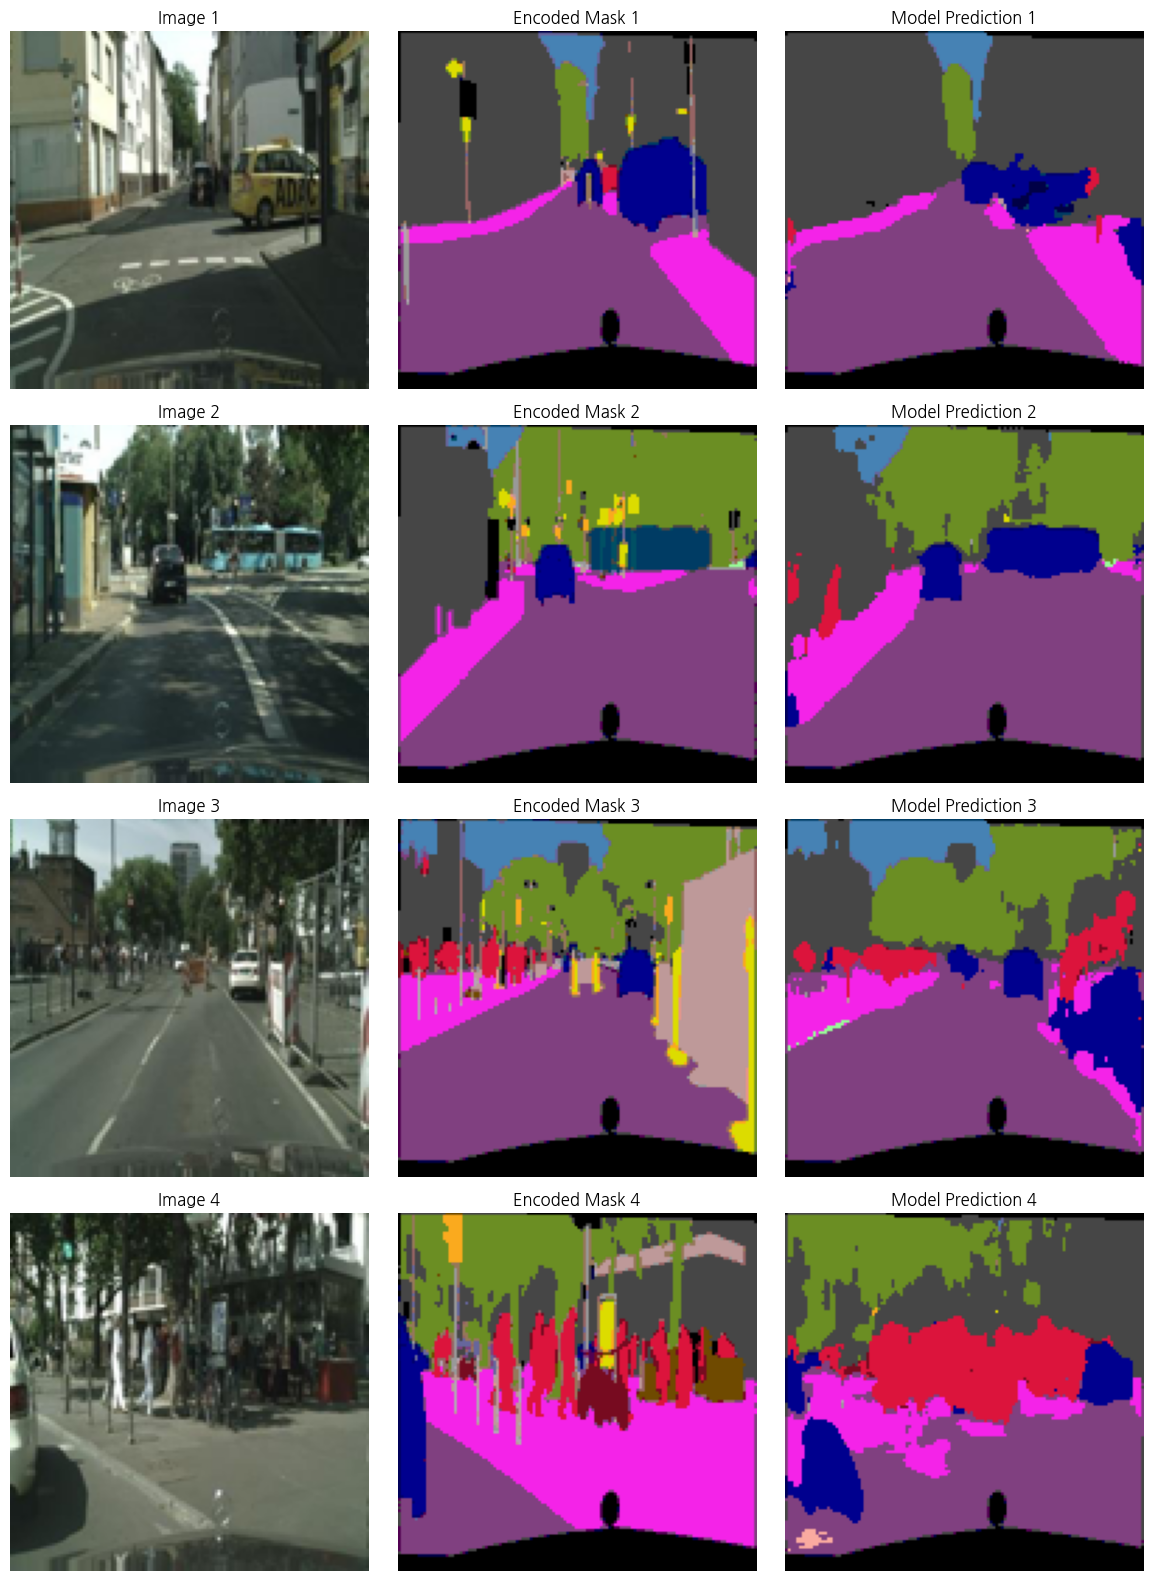

In [79]:
from tensorflow.keras.models import load_model

model = load_model('cityscapes-unet.weights.h5')

plt.figure(figsize=[15, 20])


for i in range(4):
    img = val_images[i]  # i번째 이미지를 가져온다.
    enc = val_masks_enc[i]  # i번째 이미지에 대한 정답 마스크를 가져온다.

    # 이미지를 모델에 전달하여 예측을 생성합니다.
    # reshape 함수를 사용하여 입력을 모델이 예상하는 형태로 만듭니다.
    pred = model.predict(img.reshape([1] + [image_size, image_size, 3]))
    # 예측 결과는 각 클래스에 대한 확률을 포함하므로 argmax 함수를 사용하여 가장 높은 확률을 가진 클래스를 선택합니다.
    pred = np.squeeze(np.argmax(pred, axis=-1))

    # 마스크와 예측을 시각화할 빈 이미지를 생성합니다.
    tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])
    tmp2 = np.zeros([enc.shape[0], enc.shape[1], 3])

    # 각 픽셀에 대해 반복합니다.
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            # 각 픽셀의 레이블에 해당하는 색을 id2color 사전에서 찾아서 임시 이미지에 할당합니다.
            tmp1[row, col, :] = id2color[enc[row, col]]
            tmp1 = tmp1.astype("uint8")  # uint8 형식으로 변환합니다.

            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype("uint8")  # uint8 형식으로 변환합니다.

    # 원본 이미지, 마스크, 예측 결과를 그림에 그립니다.
    plt.subplot(4, 3, i * 3 + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.gca().set_title("Image {}".format(str(i + 1)))

    plt.subplot(4, 3, i * 3 + 2)
    plt.imshow(tmp1)
    plt.axis("off")
    plt.gca().set_title("Encoded Mask {}".format(str(i + 1)))

    plt.subplot(4, 3, i * 3 + 3)
    plt.imshow(tmp2)
    plt.axis("off")
    plt.gca().set_title("Model Prediction {}".format(str(i + 1)))


# subplot 사이의 간격을 조정.
plt.subplots_adjust(wspace=0, hspace=0.1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step


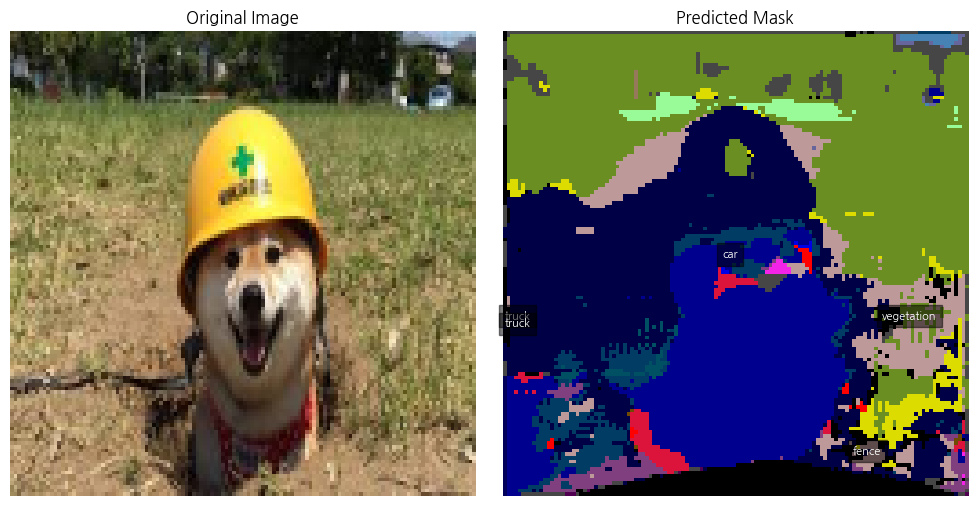

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy.ndimage import label, center_of_mass
from collections import namedtuple


# 모델 로드
model = load_model("cityscapes-unet.weights.h5")


# 테스트할 이미지 경로
image_path = "perspective_test.jpg"


# 모델 입력 크기
IMAGE_SIZE = 128


# 클래스 ID -> 색상 변환 딕셔너리
id2color = {label.id: label.color for label in labels}
id2name = {label.id: label.name for label in labels}


# 이미지 로드 및 전처리
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식이므로 RGB로 변환
img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # 모델 입력 크기로 조정
img_input = img_resized / 255.0  # 정규화
img_input = np.expand_dims(img_input, axis=0)  # 배치 차원 추가


# 모델 예측
pred = model.predict(img_input)
pred_mask = np.argmax(pred.squeeze(), axis=-1)  # 가장 높은 확률의 클래스로 변환


# 예측 결과를 컬러 마스크로 변환
pred_colored = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)
for row in range(IMAGE_SIZE):
    for col in range(IMAGE_SIZE):
        if pred_mask[row, col] in id2color:
            pred_colored[row, col, :] = id2color[pred_mask[row, col]]


# 객체의 중심 좌표 찾기
labeled_mask, num_features = label(pred_mask)  # 객체 라벨링
centers = center_of_mass(pred_mask, labeled_mask, range(1, num_features + 1))


# 시각화
plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.imshow(img_resized)
plt.axis("off")
plt.title("Original Image")


plt.subplot(1, 2, 2)
plt.imshow(pred_colored)
plt.axis("off")
plt.title("Predicted Mask")


# 각 클래스 라벨을 예측 이미지 위에 추가
for i, center in enumerate(centers):
    if center is not None:
        y, x = int(center[0]), int(center[1])
        class_id = pred_mask[y, x]
        if class_id in id2name:
            plt.text(
                x,
                y,
                id2name[class_id],
                fontsize=8,
                color="white",
                bbox=dict(facecolor="black", alpha=0.5),
            )


plt.tight_layout()
plt.show()
